# This demo show how self-training help to improves the decision boundary
1) We choose logitic regression as the classifier due to its simplicity </p>
2) Please use Python3 kernel.

Author: Yingsong Zhang


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [1]:
# visulization helper function

def show_progress(logreg,X_label,Y_label,X_semi=[],Y_semi=[],markerd ='s'):
    """This function plot the decision boundary,
    X: all the records of features
    X_label: all the records with known labels
    X_semi: records with unknown labels and in the training set
    Y_semi: the estimated labels of X_semi
    """
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    
    plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('Set1'),alpha=0.1)

    # Plot the training points using different markers
    if len(X_semi):
        #print(len(X_semi))
        plt.scatter(X_semi[:, 0], X_semi[:, 1], c=Y_semi, edgecolors='k', cmap=plt.get_cmap('Set1'),marker='^')
    
    plt.scatter(X_label[:, 0], X_label[:, 1], c=Y_label, edgecolors='k', cmap=plt.get_cmap('Set1'),s=60,marker=markerd)


        



    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

In [2]:
# self-training helper function:
def add_instance(classifier,X_semi,Y_semi,X_unlabel,belif = 0.8):
    z = classifier.predict(X_unlabel) # get predicted label
    prob = classifier.predict_proba(X_unlabel)[range(len(z)),z]  # get the prediction probability
    df = pd.DataFrame(np.vstack((z,prob)).transpose())
    new_instance = np.array(df.groupby(0)[1].agg(lambda grp: grp.argmax()).astype(int))
    new_instance = new_instance[prob[new_instance]>belif] # if you change this the result will be different
     
    # add new instances for training new model
    try:
        X_semi = np.concatenate([X_semi,X_unlabel[new_instance,:]],axis=0)
        Y_semi = np.concatenate([Y_semi,z[new_instance]],axis=0)
    except:
        X_semi=X_unlabel[new_instance,:]
        Y_semi = z[new_instance]
        
    left = list(set(df.index) - set(new_instance))
    X_unlabel = X_unlabel[left,:]
     
    return X_semi,Y_semi,X_unlabel
     

In [3]:
# self-training helper function:
def del_instance(classifier,X_semi,Y_semi,X_unlabel):
    z = classifier.predict(X_semi) # get predicted label
    prob = classifier.predict_proba(X_semi)[range(len(z)),z]  # get the prediction probability
    df = pd.DataFrame(np.vstack((z-Y_semi,prob,z-Y_semi)).transpose())


    df = df[df[2]!=0] # only the one with contradicting labels with the last step
    if len(df)>0:
        new_instance = np.array(df.groupby(0)[1].agg(lambda grp: grp.argmin()).astype(int))
      
        # add new instances to the unlabel set
        X_unlabel = np.concatenate([X_semi,X_semi[new_instance,:]],axis=0)
    
        left = list(set(df.index) - set(new_instance))
        X_semi = X_semi[left,:]
        Y_semi = Y_semi[left,:] 
    return X_semi,Y_semi,X_unlabel

# import the Iris data to play with

In [4]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

### we train a logistic regression classifier with all the records to serve as the base line for comparison

Warning!
The accuracy score on the whole labelled data is just to show how the 
self-training is compared against the whoe data set training. 
There is no intention to do any kind of cross-validation in this example.
Don't use this as a CV example.

Accuracy score on the whole labelled data set: 0.807


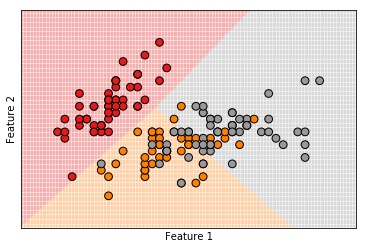

In [5]:
# Create an instance of logistic regression classifier and fit the data.
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
show_progress(logreg,X,Y,markerd='o')
print("""Warning!
The accuracy score on the whole labelled data is just to show how the 
self-training is compared against the whoe data set training. 
There is no intention to do any kind of cross-validation in this example.
Don't use this as a CV example.\n""")
print ('Accuracy score on the whole labelled data set: {:.3f}'.format(accuracy_score(logreg.predict(X),Y)))

## now we start the demo for semi-supervised learning
### You can change the random_state to view different senario, 
There is some senario that the decision boundary does not improve 

1) start the first classifier with labelled data only

add new instance
1, accuracy score on the whole label data set: 0.793
add new instance
2, accuracy score on the whole label data set: 0.800
add new instance
3, accuracy score on the whole label data set: 0.807
del new instance
4, accuracy score on the whole label data set: 0.807
add new instance
5, accuracy score on the whole label data set: 0.813
add new instance
6, accuracy score on the whole label data set: 0.813
add new instance
7, accuracy score on the whole label data set: 0.813
del new instance
8, accuracy score on the whole label data set: 0.813
add new instance
9, accuracy score on the whole label data set: 0.813
add new instance
10, accuracy score on the whole label data set: 0.813
add new instance
11, accuracy score on the whole label data set: 0.813
del new instance
12, accuracy score on the whole label data set: 0.813
add new instance
13, accuracy score on the whole label data set: 0.820
add new instance
14, accuracy score on the whole label data set: 0.827
add new instanc

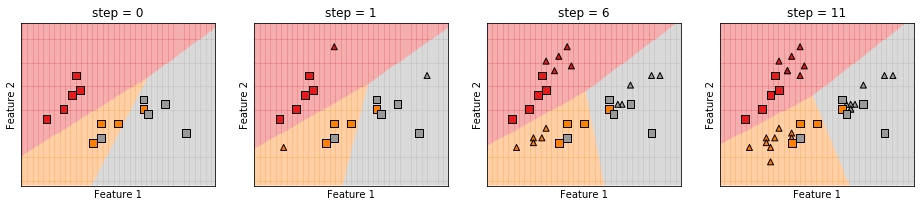

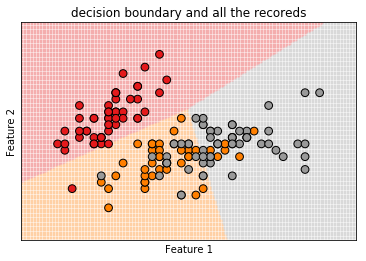

In [6]:
# randomly split the data into labelled and unlabeled data sets, 
X_label, X_unlabel, Y_label, Y_unlabel = train_test_split( X, Y, test_size=0.9, random_state=5)

# initialization
#  X_semi : unlabeled data in the training set, initialize with empty set
X_semi,Y_semi = [],[]

# Create an instance of logistic regression classifier and fit the labelled data.
logreg_semi = linear_model.LogisticRegression(C=1e5);
logreg_semi.fit(X_label, Y_label);

indd = 0
#plot decision boundary of the first classifier

fig,axes=plt.subplots(1,4,figsize=(16,3));
fig.sca(axes[indd]);
indd +=1
show_progress(logreg_semi,X_label,Y_label);
plt.title('step = 0')


for k in range(1,16):
    if k%4>0:
        X_semi,Y_semi,X_unlabel = add_instance(logreg_semi,X_semi,Y_semi,X_unlabel)
        print('add new instance')
    else:
        X_semi,Y_semi,X_unlabel = del_instance(logreg_semi,X_semi,Y_semi,X_unlabel)
        print('del new instance')
        
        
        
    X_train = np.concatenate([X_label,X_semi],axis=0)
    Y_train = np.concatenate([Y_label,Y_semi],axis=0)
    logreg_semi.fit(X_train, Y_train)
    
    z = logreg_semi.predict(X)
    
    if k%5==1:
        fig.sca(axes[indd])
        indd +=1
        show_progress(logreg_semi,X_label,Y_label,X_semi,Y_semi)
        plt.title('step = '+str(k))


    
    print ('{}, accuracy score on the whole label data set: {:.3f}'.format(k,accuracy_score(logreg_semi.predict(X),Y)))
    
#
plt.figure()
show_progress(logreg_semi,X,Y,markerd='o')
plt.title('decision boundary and all the recoreds')